# Setup

In [1]:
import os
import praw
from dotenv import load_dotenv
import json
from top2vec import Top2Vec
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sentence_transformers import SentenceTransformer
import os
import tensorflow as tf
import tensorflow_hub as hub



# Load variables from .env
load_dotenv()
client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_CLIENT_SECRET')
user_agent = os.getenv("REDDIT_USER_AGENT")


# Set up the Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
)

/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-01 12:03:14.053323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 12:03:15.025834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Topic modeling using posts as documents

## Load data

In [ ]:
# Define the subreddit you want to download from
subreddit = reddit.subreddit('ClashOfClans')

data = []

# Download posts
for submission in subreddit.search("flair:Discussion", sort='hot', limit=100):
    post_data = {
        "title": submission.title,
        "selftext": submission.selftext,
        "comments": []
    }
    
    # Download comments from the current post
    submission.comments.replace_more(limit=None)  # Fetch more comments if needed
    for comment in submission.comments.list():
        post_data["comments"].append(comment.body)
    
    data.append(post_data)

# Convert to JSON
json_data = json.dumps(data, indent=4)
documents = []
for post in data:
    combined_text =  post['selftext'] + ' ' + ' '.join(post['comments'])
    documents.append(combined_text)

## Processing functions

In [3]:
# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initializations
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuations and special characters
    text = re.sub(r'\W', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join tokens back to string
    text = ' '.join(tokens)
    return text

# Test
sample_text = "This is a sample sentence, containing URLs https://www.example.com and numbers 12345."
print(preprocess(sample_text))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ilarivp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ilarivp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilarivp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


sample sentence containing url number


In [14]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
def print_topics(model):
    topic_words, word_scores, topic_nums = model.get_topics()

    for idx, topic in enumerate(topic_nums):
        print(f"Topic {idx + 1}")
        print("-------------------")
        for word, score in zip(topic_words[idx], word_scores[idx]):
            print(word, "(Score:", score,")")
        print("\n")


def preprocess_new(text):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    import string
    
    # Tokenize, remove punctuation, lowercase, remove stopwords
    tokens = word_tokenize(text)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

def compute_coherence_for_top2vec(model):
    # Preprocess documents
    texts = [preprocess_new(doc) for doc in model.documents]

    # Create a Gensim dictionary from the preprocessed documents
    dictionary = Dictionary(texts)

    # Get topic words
    topic_words, word_scores, topic_scores = model.get_topics(len(topic_nums))

    # Compute coherence for each topic
    coherences = []
    for words in topic_words:
        cm = CoherenceModel(topics=[words], texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(cm.get_coherence())

    return coherences



def compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents):
    """
    Compute the silhouette score for a given Top2Vec model.

    Parameters:
    - model: The trained Top2Vec model
    - model_to_use: The embedding model identifier for SentenceTransformer
    - preprocessed_documents: A list of preprocessed documents for embedding encoding

    Returns:
    - Silhouette score if there are multiple labels, or a message indicating there's only one label
    """

    # Retrieve document topics
    document_topics = model.get_documents_topics([i for i in range(len(model.documents))])[0]

    # Load the embedding model for SentenceTransformer
    if model_to_use == 'universal-sentence-encoder-large':
        embedding_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
        document_embeddings = get_embeddings(preprocessed_documents, embedding_model, batch_size = 12)
    else:
        embedding_model = SentenceTransformer(model_to_use)
        document_embeddings = embedding_model.encode(preprocessed_documents)

    # Convert topic scores to labels for silhouette scoring
    labels = document_topics

    # Calculate and return the silhouette score or a relevant message
    if len(set(labels)) > 1:
        silhouette = silhouette_score(document_embeddings, labels)
        return silhouette
    else:
        return "Cannot compute silhouette score for a single label"

def get_embeddings(texts, model, batch_size=32):
    """Get embeddings for a list of texts, processing in batches."""
    embeddings = []
    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model(batch_texts)
        embeddings.append(batch_embeddings)
    # Concatenate all batch embeddings together
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


## Topic modeling

In [15]:

preprocessed_documents = [preprocess(doc) for doc in documents]
preprocessed_documents = [doc for doc in preprocessed_documents if doc.strip()]

umap_args = {
    'n_neighbors': 15,  # You can play around with this number.
    'n_components': 5,
    'metric': 'cosine'
}


hdbscan_args = {
    'min_cluster_size': 10,  # Adjust this as needed
    'min_samples': 5,       # Adjust this as needed
    'metric': 'euclidean',  # or 'cosine', etc.
    'cluster_selection_method': 'eom'  # or 'leaf'
}

umap_args = {'n_neighbors': 20,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'l1',
                'cluster_selection_method': 'leaf'}

model_to_use = 'distiluse-base-multilingual-cased'
model_to_use = 'universal-sentence-encoder-large'

model = Top2Vec(
    preprocessed_documents,
    min_count = 10,
    embedding_model=model_to_use,
    workers=4,
    umap_args=umap_args,
    hdbscan_args=hdbscan_args,
    embedding_batch_size = 12
)

# model = Top2Vec(documents, embedding_model='distiluse-base-multilingual-cased', workers=4)
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)
coherences = compute_coherence_for_top2vec(model)
for idx, coherence in enumerate(coherences):
    print(f"Topic {idx}, Coherence Score: {coherence.round(4)}")

average_coherence = sum(coherences) / len(coherences)
print(f"Average Coherence Score: {average_coherence.round(4)}")


# Usage example:
result = compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents)
print(f"Silhouette Score: {str(result.round(4))}")

2023-10-01 12:19:55,626 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-10-01 12:19:55,714 - top2vec - INFO - Downloading universal-sentence-encoder-large model
INFO:top2vec:Downloading universal-sentence-encoder-large model
2023-10-01 12:20:07,277 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-10-01 12:20:21,714 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use 

[60 23 16]
Topic 0, Coherence Score: 0.2432
Topic 1, Coherence Score: 0.2448
Topic 2, Coherence Score: 0.3584
Average Coherence Score: 0.2821
Silhouette Score: 0.071


## Analyze topics

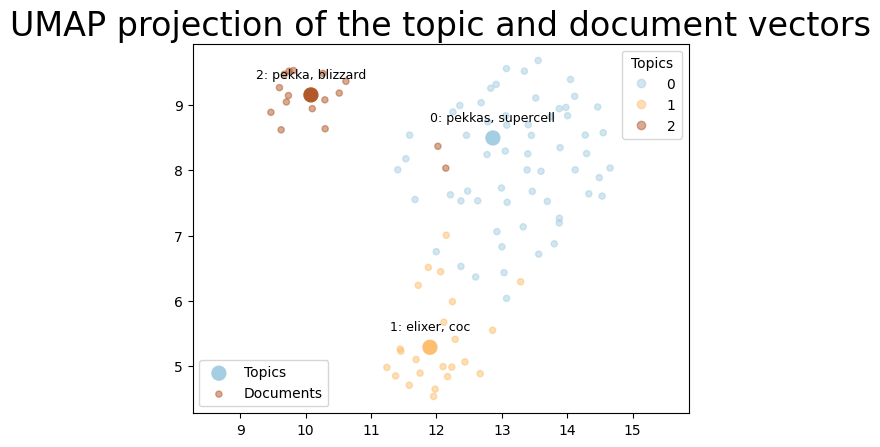

In [27]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# 1. Get topic vectors, their weights, and the top words for each topic
topic_weights, topic_nums = model.get_topic_sizes()
topic_vectors = model.topic_vectors
topic_words, word_scores, _ = model.get_topics()

# Create a set to keep track of already used words
used_words = set()

# Function to get two unique top words for each topic
def get_top_words(words):
    top_words = []
    for word in words:
        if word not in used_words:
            top_words.append(word)
            used_words.add(word)
        if len(top_words) == 2:
            break
    return ', '.join(top_words)

# Get two top words for each topic
top_words = [get_top_words(words) for words in topic_words]

# 2. Get document vectors and document topics
document_vectors = model.document_vectors
document_topics = model.doc_top  # Use model.doc_top to get the topic assignments

# Create a unique color for each topic number
unique_topics = np.unique(document_topics)
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_topics)))  # Use the 'Paired' colormap
colormap = ListedColormap(colors)

# 5. Plot the embeddings

# Prepare the colors for topic points based on the unique topic numbers
topic_colors = colormap(unique_topics / max(unique_topics))

# Plotting topic vectors with their weights
plt.scatter(topic_embedding[:, 0], topic_embedding[:, 1], s=100, c=topic_colors, alpha=1, label='Topics')

# Plotting document vectors colored by topic (adjust size and alpha to your preference)
sc = plt.scatter(document_embedding[:, 0], document_embedding[:, 1], s=20, alpha=0.5, c=document_topics, cmap=colormap, label='Documents')

# Create a legend for document colors
legend1 = plt.legend(*sc.legend_elements(), title="Topics")
plt.gca().add_artist(legend1)

# Annotate each topic number along with the top words from the topic
for i, num in enumerate(topic_nums):
    annotation = f"{num}: {top_words[i]}"
    plt.annotate(
        annotation, 
        (topic_embedding[i, 0], topic_embedding[i, 1]), 
        fontsize=9, 
        ha='center', 
        va='bottom',  # align the bottom of the text
        xytext=(0, 10),  # shift text 10 points upward
        textcoords='offset points'
    )


# Adjusting the plot visuals
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the topic and document vectors', fontsize=24)
plt.legend()
plt.show()

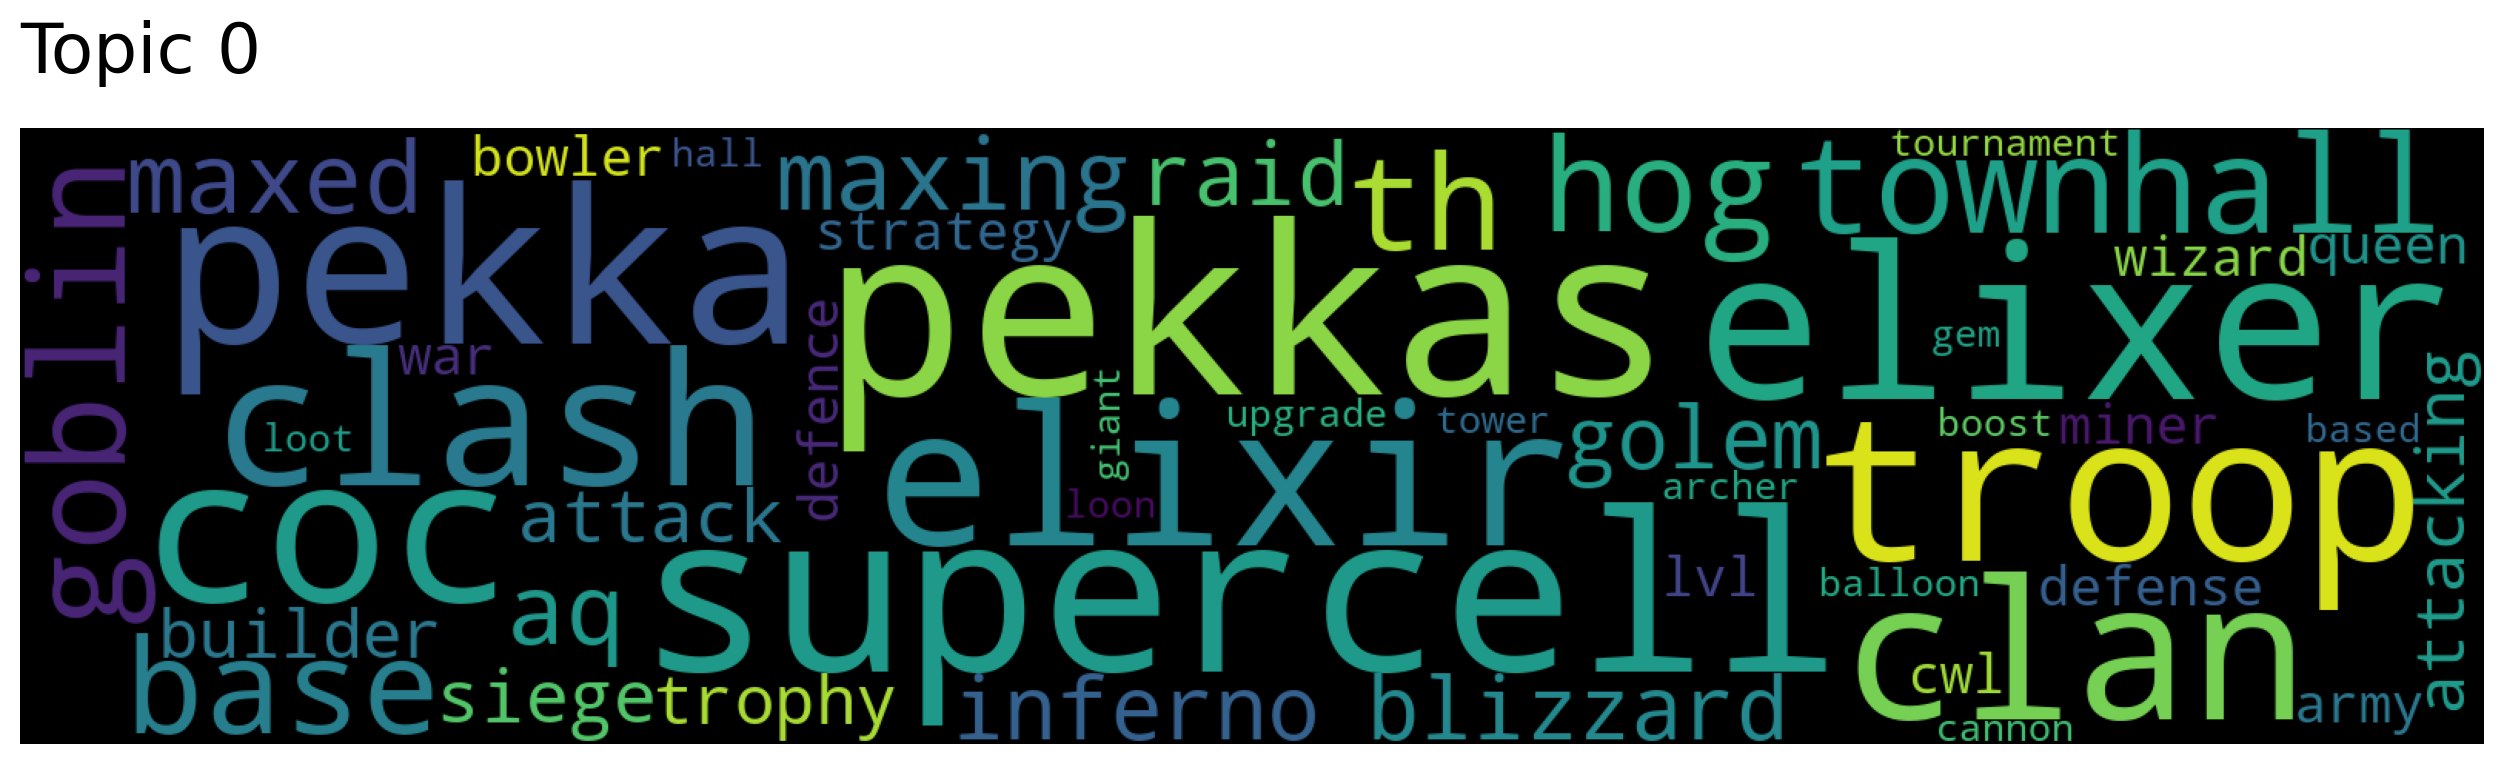

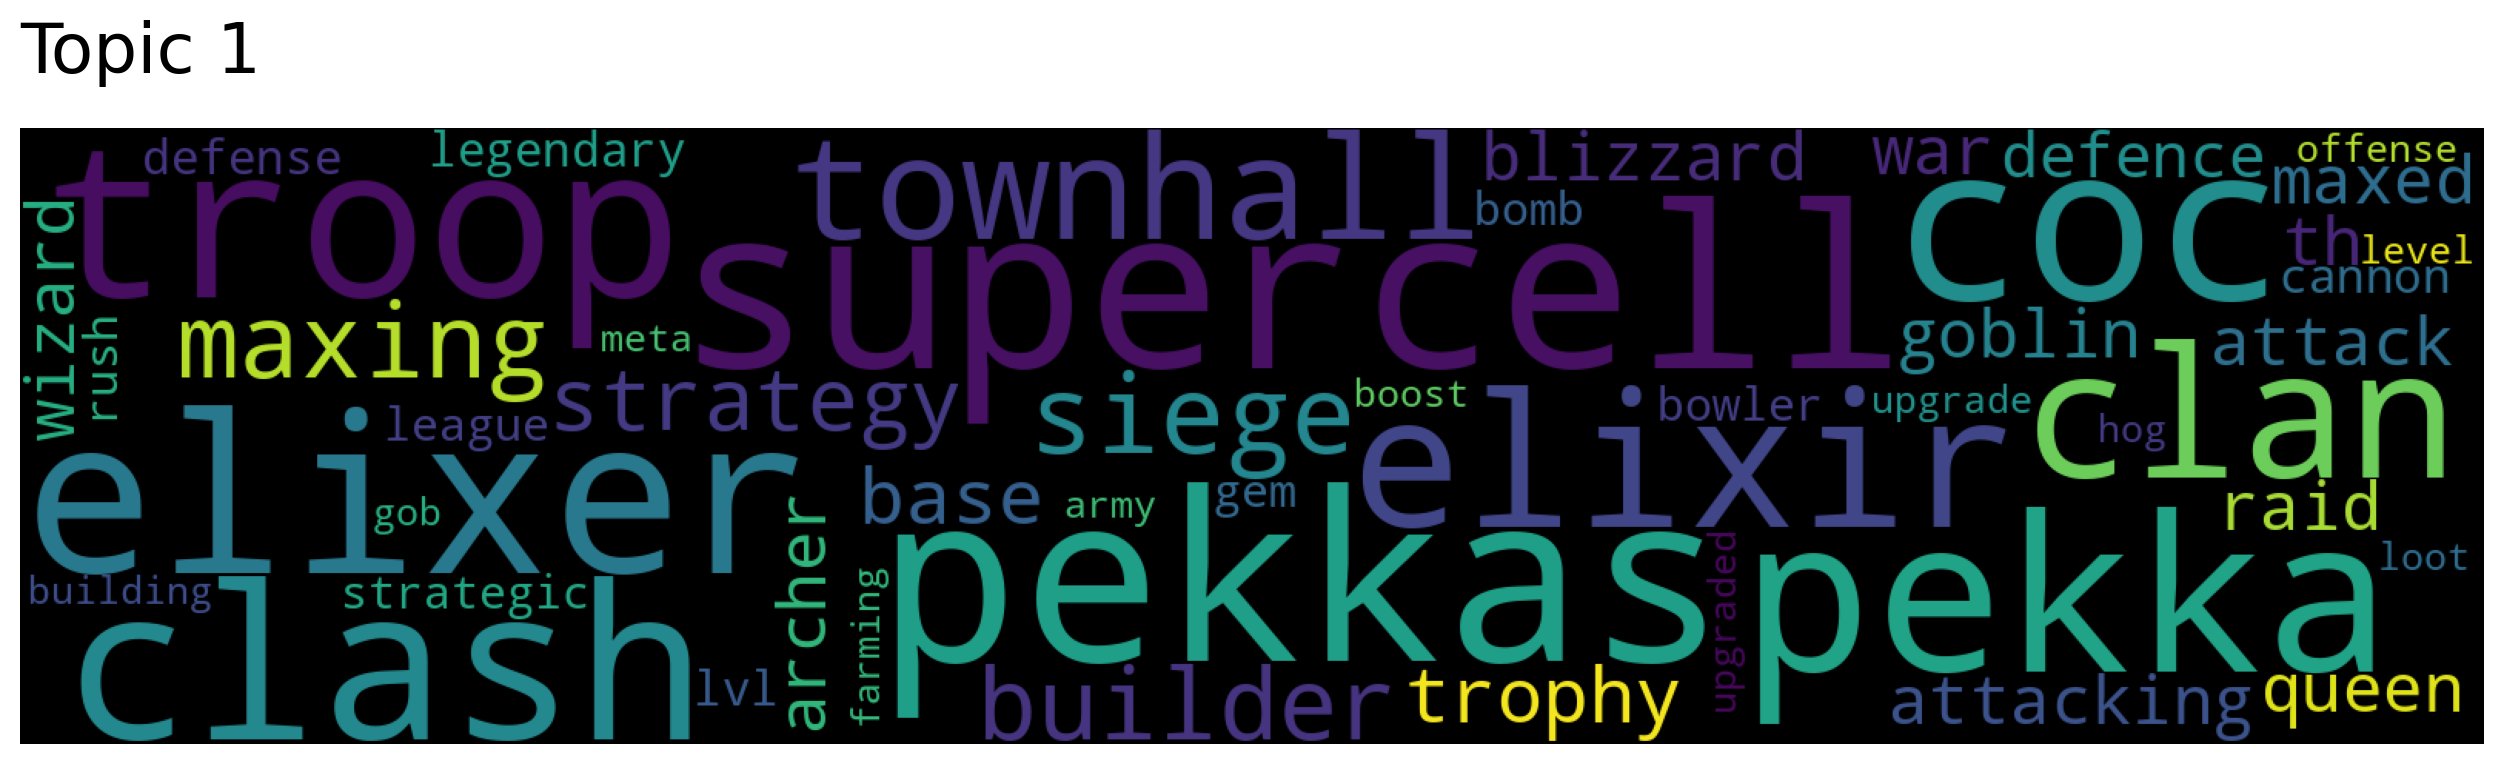

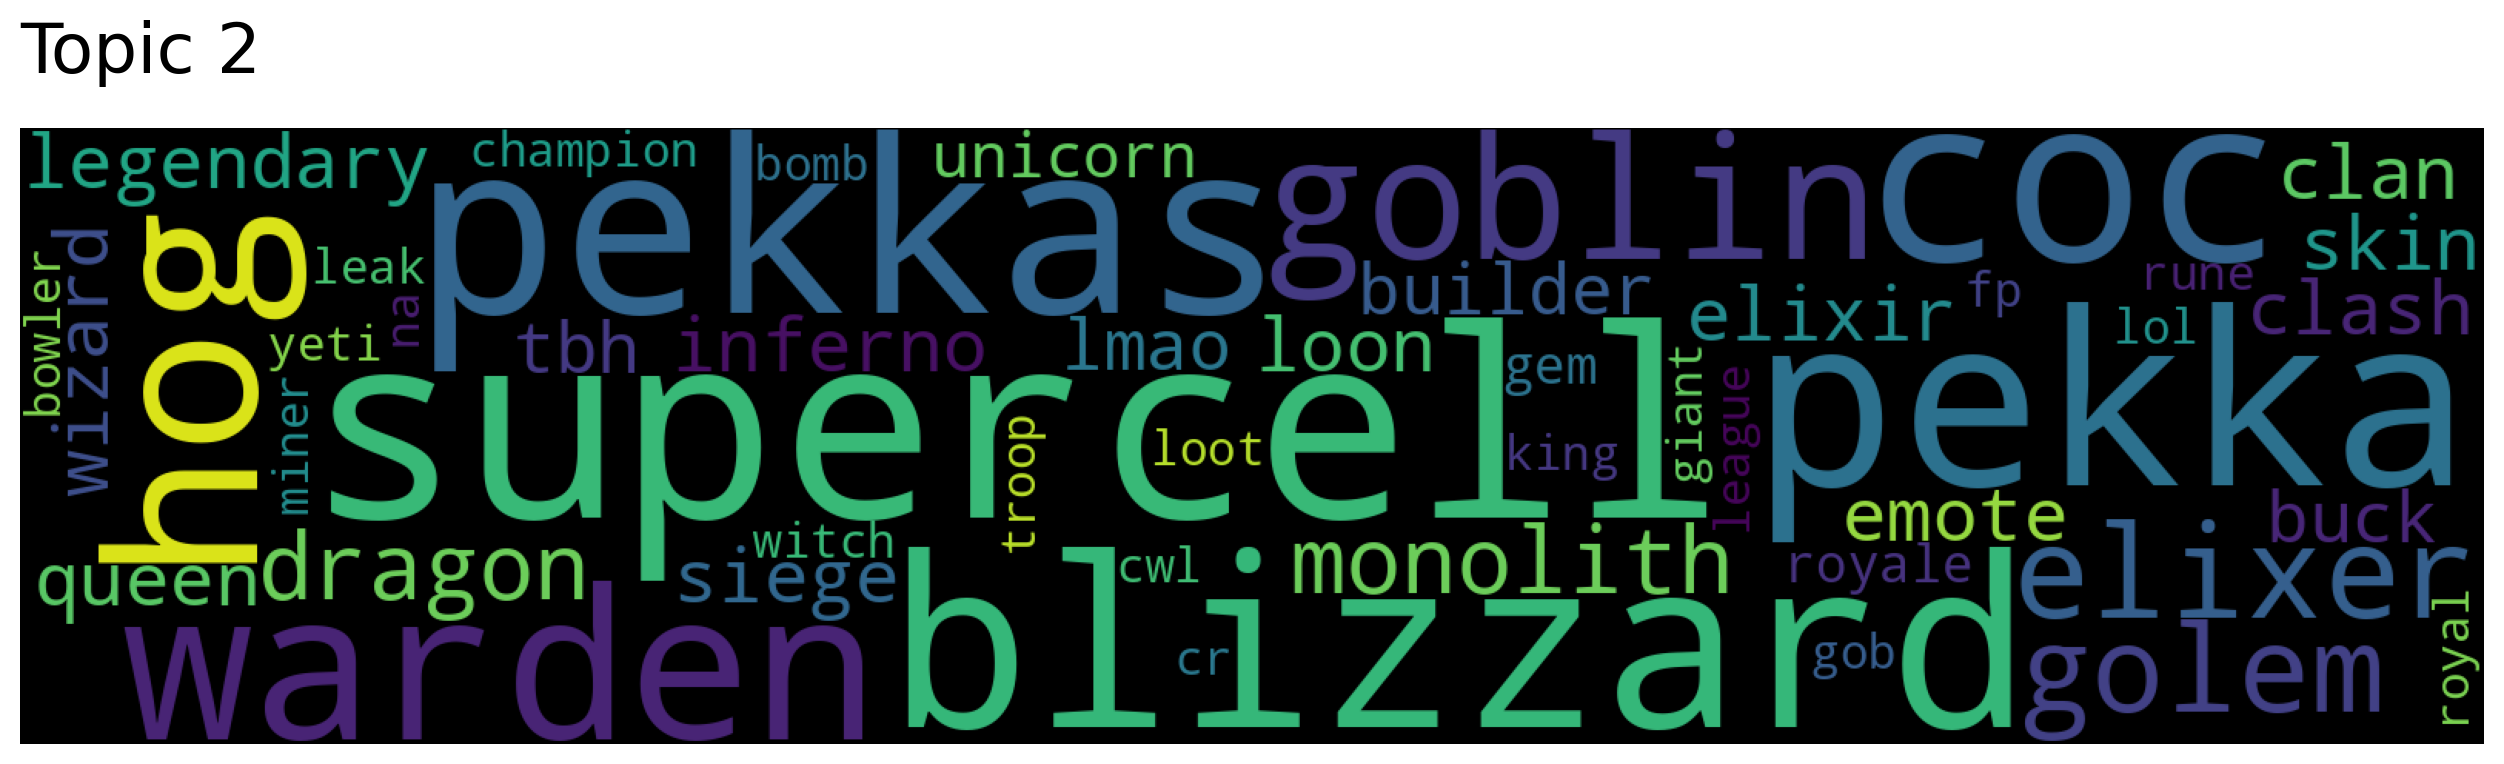

In [28]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

# Topic modeling using comment chains as documents

In [29]:
def get_comment_chain(comment):
    chain_text = comment.body
    for reply in comment.replies:
        chain_text += '\n' + get_comment_chain(reply)
    return chain_text

data = []

# Download posts
for submission in subreddit.search("flair:Discussion", sort='hot', limit=100):
    post_data = {
        "title": submission.title,
        "selftext": submission.selftext,
        "comment_chains": []
    }

    # Download comments from the current post
    submission.comments.replace_more(limit=None)  # Fetch more comments if needed
    for comment in submission.comments:
        comment_chain_text = get_comment_chain(comment)
        post_data["comment_chains"].append(comment_chain_text)

    data.append(post_data)

# Save the collected data to a JSON file
with open('reddit_data_comment_chain.json', 'w') as f:
    json.dump(data, f, indent=4)


In [34]:
# Load the collected data from the JSON file
with open('reddit_data_comment_chain.json', 'r') as f:
    data = json.load(f)

documents = []
# Process the data into documents for topic modeling
for post in data:
    for comment_chain in post['comment_chains']:
        combined_text = post['title'] + ' ' + post['selftext'] + ' ' + comment_chain
        # Each comment chain is treated as a separate document
        documents.append(combined_text)

# Now 'documents' is ready for topic modeling


In [37]:

preprocessed_documents = [preprocess(doc) for doc in documents]
preprocessed_documents = [doc for doc in preprocessed_documents if doc.strip()]

umap_args = {
    'n_neighbors': 15,  # You can play around with this number.
    'n_components': 5,
    'metric': 'cosine'
}


hdbscan_args = {
    'min_cluster_size': 10,  # Adjust this as needed
    'min_samples': 5,       # Adjust this as needed
    'metric': 'euclidean',  # or 'cosine', etc.
    'cluster_selection_method': 'eom'  # or 'leaf'
}

umap_args = {'n_neighbors': 20,
             'n_components': 5,
             'metric': 'cosine'}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'l1',
                'cluster_selection_method': 'leaf'}

model_to_use = 'distiluse-base-multilingual-cased'
model_to_use = 'universal-sentence-encoder-large'

model = Top2Vec(
    preprocessed_documents,
    min_count = 40,
    embedding_model=model_to_use,
    workers=4,
    umap_args=umap_args,
    hdbscan_args=hdbscan_args,
    embedding_batch_size = 36
)

# model = Top2Vec(documents, embedding_model='distiluse-base-multilingual-cased', workers=4)
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)
coherences = compute_coherence_for_top2vec(model)
for idx, coherence in enumerate(coherences):
    print(f"Topic {idx}, Coherence Score: {coherence.round(4)}")

average_coherence = sum(coherences) / len(coherences)
print(f"Average Coherence Score: {average_coherence.round(4)}")


# Usage example:
result = compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents)
print(f"Silhouette Score: {str(result.round(4))}")

2023-10-01 13:29:58,140 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-10-01 13:29:58,320 - top2vec - INFO - Downloading universal-sentence-encoder-large model
INFO:top2vec:Downloading universal-sentence-encoder-large model
2023-10-01 13:30:12,203 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-10-01 13:30:22,224 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-10-01 13:30:28,667 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-10-01 13:30:28,705 - top2vec - INFO - Finding topics
INFO:

[189 118 108  82  78  73  46  39  38  37  34  32  32  32  31  30  29  27
  27  27  27  25  24  20  20  20  17  17  16  16  16  16  16  15  15  15
  14  14  14  14  13  13  12  12  12  12  11  10]
Topic 0, Coherence Score: 0.2405
Topic 1, Coherence Score: 0.3688
Topic 2, Coherence Score: 0.3161
Topic 3, Coherence Score: 0.2543
Topic 4, Coherence Score: 0.2576
Topic 5, Coherence Score: 0.2446
Topic 6, Coherence Score: 0.3732
Topic 7, Coherence Score: 0.3063
Topic 8, Coherence Score: 0.2994
Topic 9, Coherence Score: 0.2531
Topic 10, Coherence Score: 0.3562
Topic 11, Coherence Score: 0.2283
Topic 12, Coherence Score: 0.3012
Topic 13, Coherence Score: 0.2825
Topic 14, Coherence Score: 0.2611
Topic 15, Coherence Score: 0.2395
Topic 16, Coherence Score: 0.2372
Topic 17, Coherence Score: 0.3647
Topic 18, Coherence Score: 0.2987
Topic 19, Coherence Score: 0.2681
Topic 20, Coherence Score: 0.2351
Topic 21, Coherence Score: 0.223
Topic 22, Coherence Score: 0.2966
Topic 23, Coherence Score: 0.3125

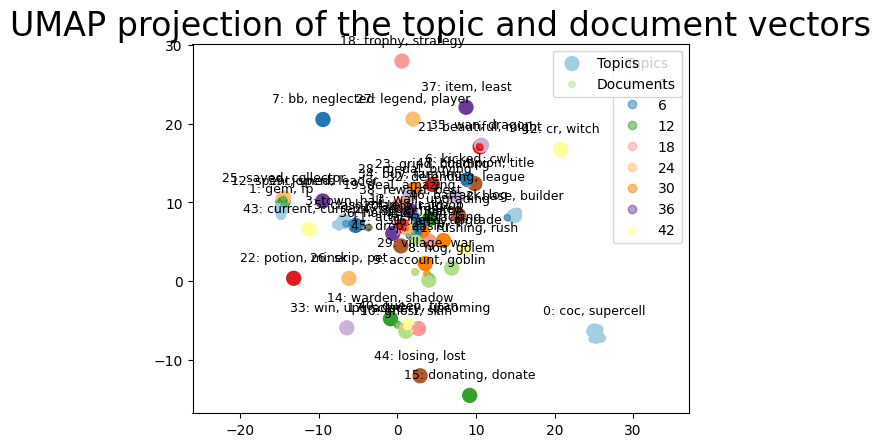

In [38]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# 1. Get topic vectors, their weights, and the top words for each topic
topic_weights, topic_nums = model.get_topic_sizes()
topic_vectors = model.topic_vectors
topic_words, word_scores, _ = model.get_topics()

# Create a set to keep track of already used words
used_words = set()

# Function to get two unique top words for each topic
def get_top_words(words):
    top_words = []
    for word in words:
        if word not in used_words:
            top_words.append(word)
            used_words.add(word)
        if len(top_words) == 2:
            break
    return ', '.join(top_words)

# Get two top words for each topic
top_words = [get_top_words(words) for words in topic_words]

# 2. Get document vectors and document topics
document_vectors = model.document_vectors
document_topics = model.doc_top  # Use model.doc_top to get the topic assignments

# Create a unique color for each topic number
unique_topics = np.unique(document_topics)
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_topics)))  # Use the 'Paired' colormap
colormap = ListedColormap(colors)

# 3. Combine topic vectors and document vectors for UMAP transformation
all_vectors = np.vstack([topic_vectors, document_vectors])

# 4. Reduce dimensions using UMAP on the combined set of vectors
reducer = umap.UMAP(init='random')
embedding = reducer.fit_transform(all_vectors)

# Split the embeddings back into topics and documents
topic_embedding = embedding[:len(topic_vectors)]
document_embedding = embedding[len(topic_vectors):]

# 5. Plot the embeddings

# Prepare the colors for topic points based on the unique topic numbers
topic_colors = colormap(unique_topics / max(unique_topics))

# Plotting topic vectors with their weights
plt.scatter(topic_embedding[:, 0], topic_embedding[:, 1], s=100, c=topic_colors, alpha=1, label='Topics')

# Plotting document vectors colored by topic (adjust size and alpha to your preference)
sc = plt.scatter(document_embedding[:, 0], document_embedding[:, 1], s=20, alpha=0.5, c=document_topics, cmap=colormap, label='Documents')

# Create a legend for document colors
legend1 = plt.legend(*sc.legend_elements(), title="Topics")
plt.gca().add_artist(legend1)

# Annotate each topic number along with the top words from the topic
for i, num in enumerate(topic_nums):
    annotation = f"{num}: {top_words[i]}"
    plt.annotate(
        annotation, 
        (topic_embedding[i, 0], topic_embedding[i, 1]), 
        fontsize=9, 
        ha='center', 
        va='bottom',  # align the bottom of the text
        xytext=(0, 10),  # shift text 10 points upward
        textcoords='offset points'
    )


# Adjusting the plot visuals
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the topic and document vectors', fontsize=24)
plt.legend()
plt.show()